# Anomaly Detection for IoT Devices

A brief for this project.

### Getting all dependencies for creating a virtual envionment

In [1236]:
%%bash
set -e

pip install virtualenv

# Create virtual environment
python3 -m virtualenv myenv
source ./myenv/bin/activate
./myenv/bin/pip install ipykernel
./myenv/bin/pip install numpy pandas scikit-learn matplotlib seaborn imblearn
./myenv/bin/pip freeze > requirements.txt
python3 -m ipykernel install --user --name=myenv --display-name "Python3 (myenv)"


created virtual environment CPython3.10.12.final.0-64 in 117ms
  creator CPython3Posix(dest=/home/joao/inatel/P10/C318/Project/myenv, clear=False, no_vcs_ignore=False, global=False)
  seeder FromAppData(download=False, pip=bundle, setuptools=bundle, wheel=bundle, via=copy, app_data_dir=/home/joao/snap/code/174/.local/share/virtualenv)
    added seed packages: asttokens==2.4.1, comm==0.2.2, contourpy==1.3.1, cycler==0.12.1, debugpy==1.8.8, decorator==5.1.1, distlib==0.3.9, exceptiongroup==1.2.2, executing==2.1.0, filelock==3.16.1, fonttools==4.55.0, imbalanced_learn==0.12.4, imblearn==0.0, ipykernel==6.29.5, ipython==8.29.0, jedi==0.19.2, joblib==1.4.2, jupyter_client==8.6.3, jupyter_core==5.7.2, kiwisolver==1.4.7, matplotlib==3.9.2, matplotlib_inline==0.1.7, nest_asyncio==1.6.0, numpy==2.1.3, packaging==24.2, pandas==2.2.3, parso==0.8.4, pexpect==4.9.0, pillow==11.0.0, pip==24.3.1, platformdirs==4.3.6, prompt_toolkit==3.0.48, psutil==6.1.0, ptyprocess==0.7.0, pure_eval==0.2.3, pygments

In [1237]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
from datetime import datetime, timezone
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import make_scorer
from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [1238]:
def convert_timestamp(ts):
    # Convert timestamp to datetime
    dt = datetime.fromtimestamp(ts, tz=timezone.utc)
    # Format the datetime to the desired string format
    formatted = dt.strftime('%Y-%m-%d %H:%M:%S.') + f"{dt.microsecond // 1000:03d} {dt.strftime('%z')}"
    # Adjust timezone formatting to include the colon
    formatted = formatted[:-2] + ":" + formatted[-2:]
    return formatted

### Lendo o dataset

In [1239]:
df_feature = pd.read_csv('./dataset/dvc_anomalo.csv')
df_feature.head()

,id,location,device,timestamp,state,dimmer,accActiveEnergy,accReactiveEnergy,uRms,iRms,activePotency,reactivePotency,potencyFactor,luminosityLux,temperature
0,1,LOCATION 4,ANOMALO::0:zrhybacdev:cadjw3wmgc,1704751249000,0.0,100.0,17898466.0,4585384.0,22516.0,23.0,0.0,0.0,140.0,18300.0,35.0
1,2,LOCATION 4,ANOMALO::0:zrhybacdev:cadjw3wmgc,1704914640000,1.0,100.0,17907226.0,4586661.0,22442.0,649.0,145.0,-21.0,989.0,0.0,41.0
2,3,LOCATION 4,ANOMALO::0:zrhybacdev:cadjw3wmgc,1704918241000,1.0,100.0,17921644.0,4588813.0,22564.0,647.0,145.0,-21.0,989.0,0.0,40.0
3,4,LOCATION 4,ANOMALO::0:zrhybacdev:cadjw3wmgc,1704921842000,1.0,100.0,17936112.0,4591007.0,22564.0,648.0,145.0,-22.0,988.0,0.0,38.0
4,5,LOCATION 4,ANOMALO::0:zrhybacdev:cadjw3wmgc,1704925442000,1.0,100.0,17950563.0,4593223.0,22717.0,644.0,145.0,-22.0,988.0,0.0,39.0


### Visualizando métricas das colunas 

In [1240]:
df_feature.describe()

,id,timestamp,state,dimmer,accActiveEnergy,accReactiveEnergy,uRms,iRms,activePotency,reactivePotency,potencyFactor,luminosityLux,temperature
count,1666.00000,1.666000e+03,1665.000000,1665.0,1.665000e+03,1.665000e+03,1665.000000,1665.000000,1665.000000,1665.000000,1665.000000,1665.000000,1665.000000
mean,833.50000,1.714093e+12,0.514715,100.0,3.625280e+07,7.374461e+06,22688.137538,339.438438,74.552553,-11.097297,594.078679,138708.048048,39.056456
std,481.07709,3.493303e+09,0.499934,0.0,7.253462e+06,1.098369e+06,127.035242,313.319993,72.668627,10.815438,407.710763,206336.574622,7.544846
min,1.00000,1.704751e+12,0.000000,100.0,1.789847e+07,4.585384e+06,22178.000000,12.000000,0.000000,-23.000000,8.000000,0.000000,20.000000
25%,417.25000,1.711693e+12,0.000000,100.0,3.104675e+07,6.589300e+06,22608.000000,23.000000,0.000000,-22.000000,158.000000,0.000000,34.000000
50%,833.50000,1.716066e+12,1.000000,100.0,4.036568e+07,7.996753e+06,22695.000000,639.000000,144.000000,-21.000000,987.000000,9200.000000,38.000000
75%,1249.75000,1.716904e+12,1.000000,100.0,4.216844e+07,8.269609e+06,22783.000000,644.000000,145.000000,0.000000,988.000000,220100.000000,43.000000
max,1666.00000,1.717459e+12,1.000000,100.0,4.342594e+07,8.457941e+06,23008.000000,663.000000,147.000000,0.000000,994.000000,606100.000000,61.000000


### Verificando colunas com exemplos nulos

In [1241]:
df_feature.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1666 entries, 0 to 1665
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 1666 non-null   int64  
 1   location           1666 non-null   object 
 2   device             1666 non-null   object 
 3   timestamp          1666 non-null   int64  
 4   state              1665 non-null   float64
 5   dimmer             1665 non-null   float64
 6   accActiveEnergy    1665 non-null   float64
 7   accReactiveEnergy  1665 non-null   float64
 8   uRms               1665 non-null   float64
 9   iRms               1665 non-null   float64
 10  activePotency      1665 non-null   float64
 11  reactivePotency    1665 non-null   float64
 12  potencyFactor      1665 non-null   float64
 13  luminosityLux      1665 non-null   float64
 14  temperature        1665 non-null   float64
dtypes: float64(11), int64(2), object(2)
memory usage: 195.4+ KB


### Limpando o Dataset

In [1242]:
df_feature_cleaned = df_feature.dropna()
df_feature_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1664 entries, 0 to 1665
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 1664 non-null   int64  
 1   location           1664 non-null   object 
 2   device             1664 non-null   object 
 3   timestamp          1664 non-null   int64  
 4   state              1664 non-null   float64
 5   dimmer             1664 non-null   float64
 6   accActiveEnergy    1664 non-null   float64
 7   accReactiveEnergy  1664 non-null   float64
 8   uRms               1664 non-null   float64
 9   iRms               1664 non-null   float64
 10  activePotency      1664 non-null   float64
 11  reactivePotency    1664 non-null   float64
 12  potencyFactor      1664 non-null   float64
 13  luminosityLux      1664 non-null   float64
 14  temperature        1664 non-null   float64
dtypes: float64(11), int64(2), object(2)
memory usage: 208.0+ KB


### Preprocessing

In [1243]:
df_feature_cleaned.describe()

,id,timestamp,state,dimmer,accActiveEnergy,accReactiveEnergy,uRms,iRms,activePotency,reactivePotency,potencyFactor,luminosityLux,temperature
count,1664.000000,1.664000e+03,1664.000000,1664.0,1.664000e+03,1.664000e+03,1664.000000,1664.000000,1664.000000,1664.000000,1664.000000,1664.000000,1664.000000
mean,833.478365,1.714090e+12,0.514423,100.0,3.624998e+07,7.374034e+06,22688.121394,339.256010,74.510216,-11.090745,593.841346,138791.406250,39.056490
std,481.365880,3.494543e+09,0.499942,0.0,7.254727e+06,1.098561e+06,127.071723,313.325717,72.669930,10.815383,407.718264,206370.557152,7.547114
min,1.000000,1.704751e+12,0.000000,100.0,1.789847e+07,4.585384e+06,22178.000000,12.000000,0.000000,-23.000000,8.000000,0.000000,20.000000
25%,416.750000,1.711692e+12,0.000000,100.0,3.104314e+07,6.588738e+06,22608.000000,23.000000,0.000000,-22.000000,157.750000,0.000000,34.000000
50%,832.500000,1.716062e+12,1.000000,100.0,4.035845e+07,7.995666e+06,22695.000000,639.000000,144.000000,-21.000000,987.000000,9200.000000,38.000000
75%,1250.250000,1.716904e+12,1.000000,100.0,4.216844e+07,8.269609e+06,22783.000000,644.000000,145.000000,0.000000,988.000000,220150.000000,43.000000
max,1666.000000,1.717459e+12,1.000000,100.0,4.342594e+07,8.457941e+06,23008.000000,663.000000,147.000000,0.000000,994.000000,606100.000000,61.000000


In [1244]:
df_feature_cleaned.loc[:,'uRms'] = df_feature_cleaned['uRms'] / 100.0 # Convert to V
df_feature_cleaned['uRms'].describe()

count    1664.000000
mean      226.881214
std         1.270717
min       221.780000
25%       226.080000
50%       226.950000
75%       227.830000
max       230.080000
Name: uRms, dtype: float64

In [1245]:
df_feature_cleaned.loc[:,'luminosityLux'] = df_feature_cleaned['luminosityLux'] / 100.0 # Convert to Lux
df_feature_cleaned['luminosityLux'].describe()

count    1664.000000
mean     1387.914062
std      2063.705572
min         0.000000
25%         0.000000
50%        92.000000
75%      2201.500000
max      6061.000000
Name: luminosityLux, dtype: float64

In [1246]:
df_feature_cleaned.loc[:,'timestamp'] = df_feature_cleaned['timestamp'] / 1000.0
df_feature_cleaned.loc[:,'timestamp'] = df_feature_cleaned['timestamp'].apply(convert_timestamp)
df_feature_cleaned.head()

/tmp/ipykernel_667535/3228150094.py:2: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['2024-01-08 22:00:49.000 +00:00' '2024-01-10 19:24:00.000 +00:00'
 '2024-01-10 20:24:01.000 +00:00' ... '2024-06-03 23:19:30.000 +00:00'
 '2024-06-03 23:39:31.000 +00:00' '2024-06-03 23:59:32.000 +00:00']' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df_feature_cleaned.loc[:,'timestamp'] = df_feature_cleaned['timestamp'].apply(convert_timestamp)


,id,location,device,timestamp,state,dimmer,accActiveEnergy,accReactiveEnergy,uRms,iRms,activePotency,reactivePotency,potencyFactor,luminosityLux,temperature
0,1,LOCATION 4,ANOMALO::0:zrhybacdev:cadjw3wmgc,2024-01-08 22:00:49.000 +00:00,0.0,100.0,17898466.0,4585384.0,225.16,23.0,0.0,0.0,140.0,183.0,35.0
1,2,LOCATION 4,ANOMALO::0:zrhybacdev:cadjw3wmgc,2024-01-10 19:24:00.000 +00:00,1.0,100.0,17907226.0,4586661.0,224.42,649.0,145.0,-21.0,989.0,0.0,41.0
2,3,LOCATION 4,ANOMALO::0:zrhybacdev:cadjw3wmgc,2024-01-10 20:24:01.000 +00:00,1.0,100.0,17921644.0,4588813.0,225.64,647.0,145.0,-21.0,989.0,0.0,40.0
3,4,LOCATION 4,ANOMALO::0:zrhybacdev:cadjw3wmgc,2024-01-10 21:24:02.000 +00:00,1.0,100.0,17936112.0,4591007.0,225.64,648.0,145.0,-22.0,988.0,0.0,38.0
4,5,LOCATION 4,ANOMALO::0:zrhybacdev:cadjw3wmgc,2024-01-10 22:24:02.000 +00:00,1.0,100.0,17950563.0,4593223.0,227.17,644.0,145.0,-22.0,988.0,0.0,39.0


In [1247]:
df_feature_cleaned = df_feature_cleaned.drop(columns=['id'])

### Exploratory Data Analysis

<Axes: >

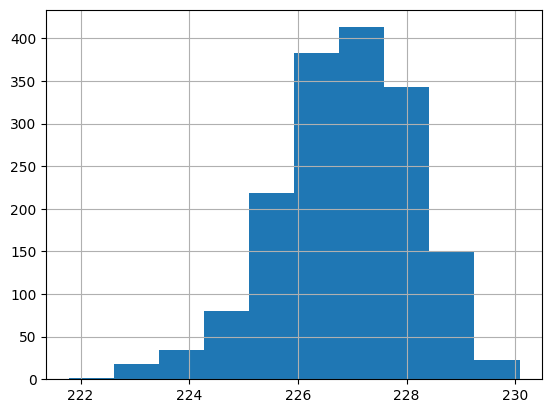

In [1248]:
voltage_column = df_feature_cleaned['uRms']
voltage_column.hist()

<Axes: >

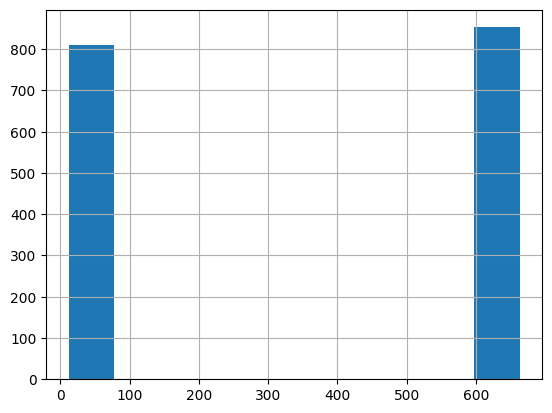

In [1249]:
current_column = df_feature_cleaned['iRms']
current_column.hist()

<Axes: >

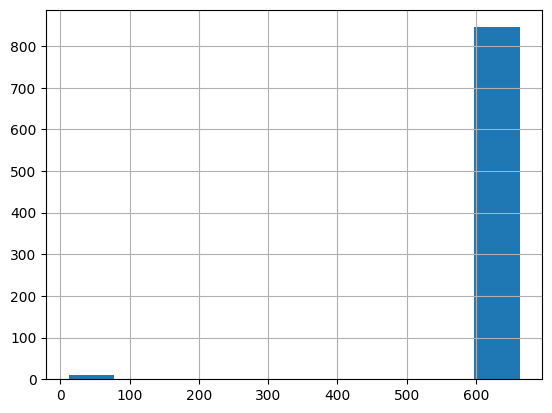

In [1250]:
current_column_night = df_feature_cleaned[df_feature_cleaned['state'] == 1] # Night
current_column_night = current_column_night['iRms']
current_column_night.hist()

<Axes: >

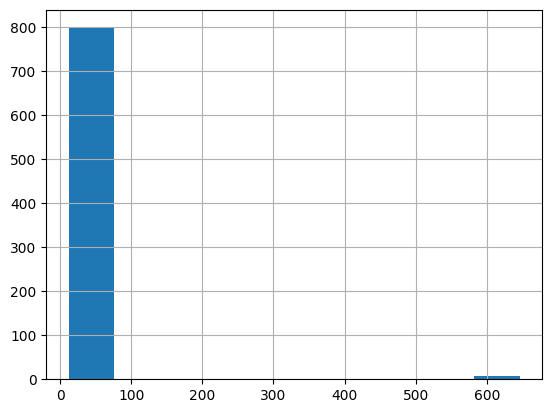

In [1251]:
current_column_day = df_feature_cleaned[df_feature_cleaned['state'] == 0] # Day
current_column_day = current_column_day['iRms']
current_column_day.hist()

<Axes: >

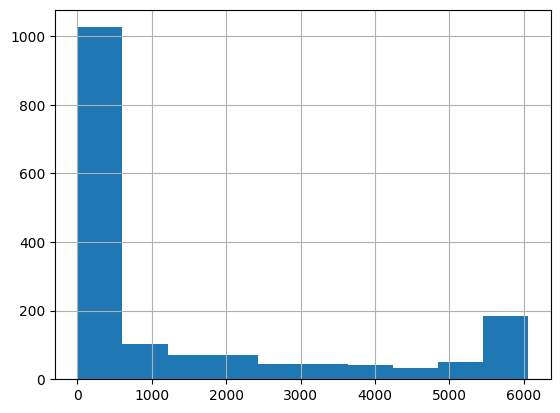

In [1252]:
luminosity_column = df_feature_cleaned['luminosityLux']
luminosity_column.hist()

<Axes: >

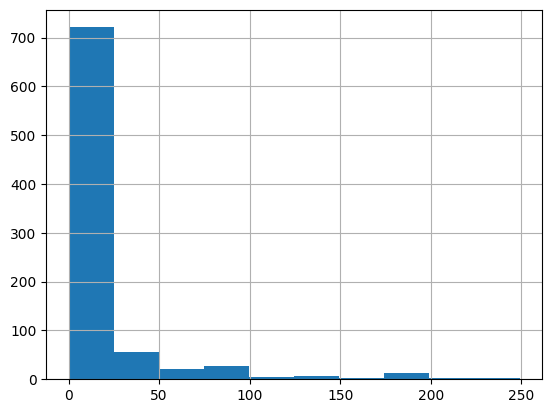

In [1253]:
luminosity_column_night = df_feature_cleaned[df_feature_cleaned['state'] == 1] # Night
luminosity_column_night = luminosity_column_night['luminosityLux']
luminosity_column_night.hist()

<Axes: >

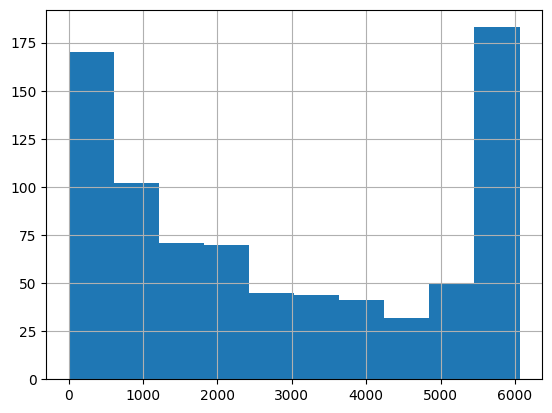

In [1254]:
luminosity_column_day = df_feature_cleaned[df_feature_cleaned['state'] == 0] # Day
luminosity_column_day = luminosity_column_day['luminosityLux']
luminosity_column_day.hist()

<Axes: >

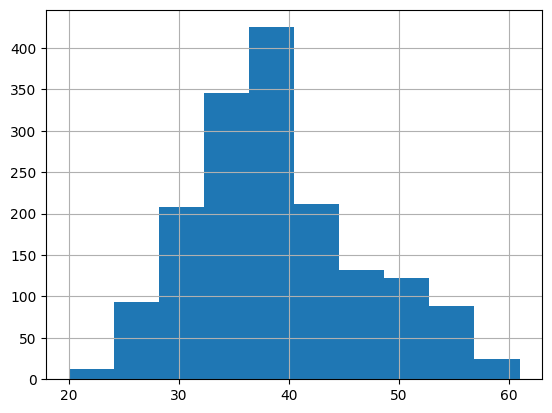

In [1255]:
temperature_column = df_feature_cleaned['temperature']
temperature_column.hist()

<Axes: >

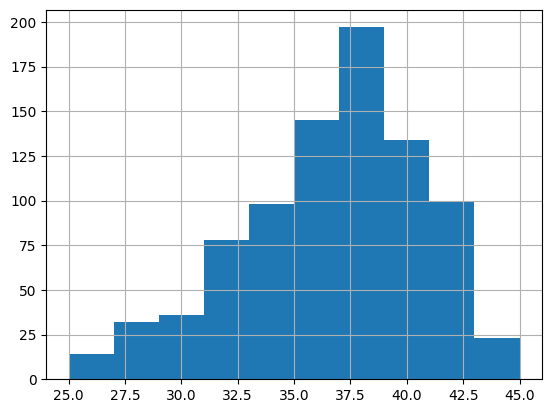

In [1256]:
temperature_column_night = df_feature_cleaned[df_feature_cleaned['state'] == 1] # Night
temperature_column_night = temperature_column_night['temperature']
temperature_column_night.hist()

<Axes: >

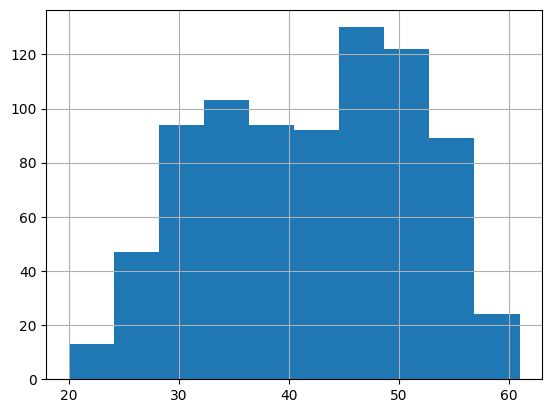

In [1257]:
temperature_column_day = df_feature_cleaned[df_feature_cleaned['state'] == 0] # Day
temperature_column_day = temperature_column_day['temperature']
temperature_column_day.hist()

<Axes: >

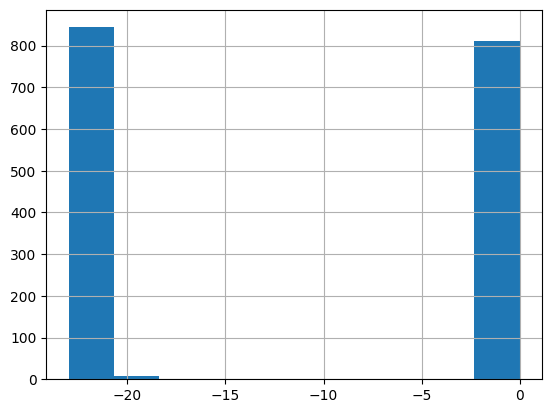

In [1258]:
reactive_potency_column = df_feature_cleaned['reactivePotency']
reactive_potency_column.hist()

<Axes: >

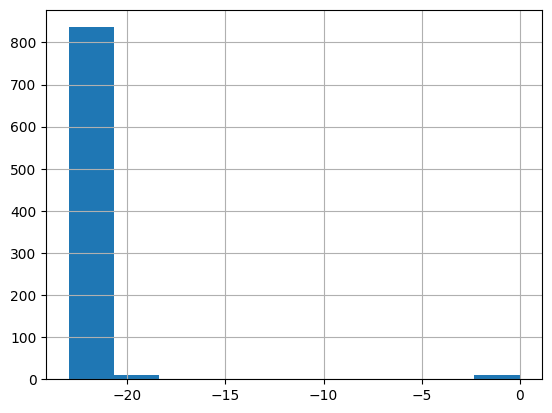

In [1259]:
reactive_potency_column_night = df_feature_cleaned[df_feature_cleaned['state'] == 1] # Night
reactive_potency_column_night = reactive_potency_column_night['reactivePotency']
reactive_potency_column_night.hist()

<Axes: >

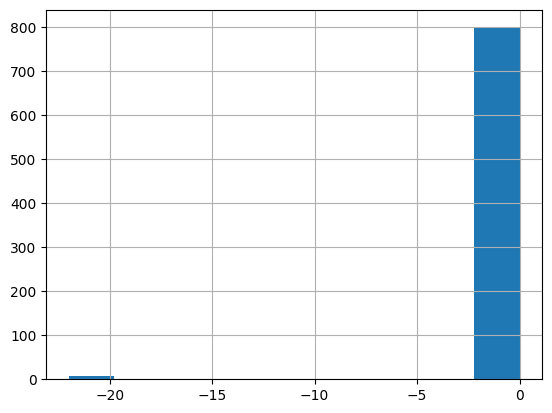

In [1260]:
reactive_potency_column_day = df_feature_cleaned[df_feature_cleaned['state'] == 0] # Day
reactive_potency_column_day = reactive_potency_column_day['reactivePotency']
reactive_potency_column_day.hist()

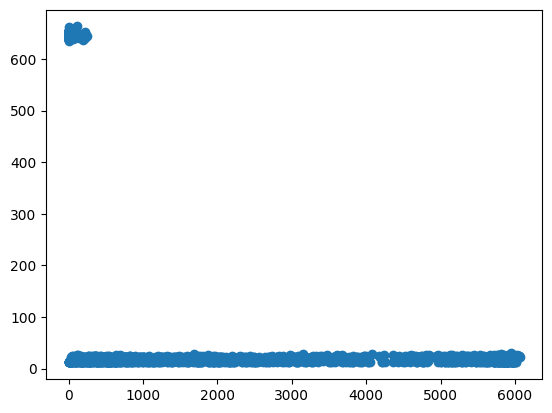

In [1261]:
plt.scatter(df_feature_cleaned['luminosityLux'], df_feature_cleaned['iRms'])
plt.show()

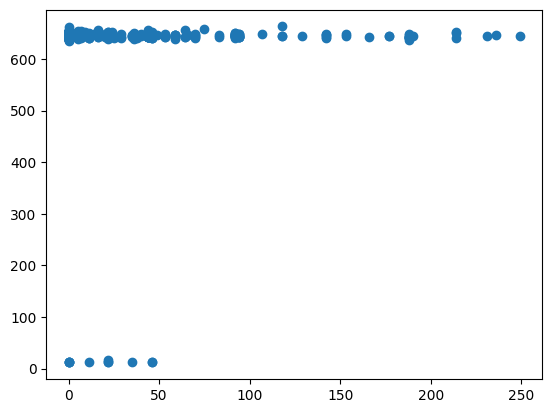

In [1262]:
plt.scatter(luminosity_column_night, current_column_night)
plt.show()

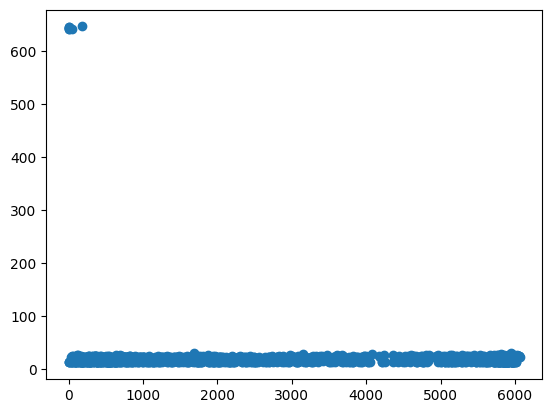

In [1263]:
plt.scatter(luminosity_column_day, current_column_day)
plt.show()

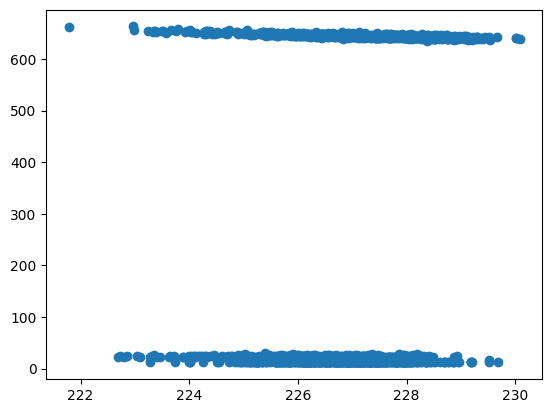

In [1264]:
plt.scatter(voltage_column, current_column)
plt.show()

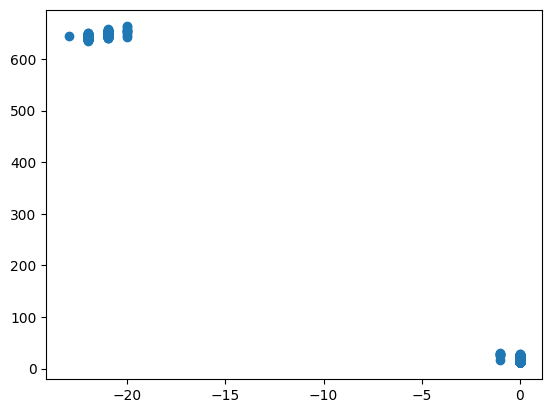

In [1265]:
plt.scatter(reactive_potency_column, current_column)
plt.show()

In [1278]:
df_feature_cleaned.columns

Index(['location', 'device', 'timestamp', 'state', 'dimmer', 'accActiveEnergy',
       'accReactiveEnergy', 'uRms', 'iRms', 'activePotency', 'reactivePotency',
       'potencyFactor', 'luminosityLux', 'temperature'],
      dtype='object')

### Binding Samples and Target

In [1266]:
df_target = pd.read_csv('./dataset/anomalo-events-sample.csv')
df_target.head()

,id,location,identification,nodeLabel,attr,value,timestamp
0,1,LOCATION 4,ANOMALO::0:zrhybacdev:cadjw3wmgc,DVC_EVENT,BLINK,NaN,2024-05-19 06:39:38.000 +00:00
1,2,LOCATION 4,ANOMALO::0:zrhybacdev:cadjw3wmgc,DVC_EVENT,BLINK,NaN,2024-05-19 06:39:38.000 +00:00
2,3,LOCATION 4,ANOMALO::0:zrhybacdev:cadjw3wmgc,DVC_EVENT,BLINK,NaN,2024-05-19 06:39:38.000 +00:00
3,4,LOCATION 4,ANOMALO::0:zrhybacdev:cadjw3wmgc,DVC_EVENT,BLINK,NaN,2024-05-19 06:39:38.000 +00:00
4,5,LOCATION 4,ANOMALO::0:zrhybacdev:cadjw3wmgc,DVC_EVENT,BLINK,NaN,2024-05-19 06:39:38.000 +00:00


In [1267]:
df_target.describe()

,id,value
count,99.000000,0.0
mean,50.000000,NaN
std,28.722813,NaN
min,1.000000,NaN
25%,25.500000,NaN
50%,50.000000,NaN
75%,74.500000,NaN
max,99.000000,NaN


In [1268]:
df_target.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99 entries, 0 to 98
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              99 non-null     int64  
 1   location        99 non-null     object 
 2   identification  99 non-null     object 
 3   nodeLabel       99 non-null     object 
 4   attr            99 non-null     object 
 5   value           0 non-null      float64
 6   timestamp       99 non-null     object 
dtypes: float64(1), int64(1), object(5)
memory usage: 5.5+ KB


In [1269]:
df_target_cleaned = df_target.drop_duplicates(subset='timestamp', keep='first')

In [1270]:
df_feature_cleaned['timestamp'] = pd.to_datetime(df_feature_cleaned['timestamp'])
df_target_cleaned['timestamp'] = pd.to_datetime(df_target_cleaned['timestamp'])
df_feature_cleaned.head()

/tmp/ipykernel_667535/4095838552.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_target_cleaned['timestamp'] = pd.to_datetime(df_target_cleaned['timestamp'])


,location,device,timestamp,state,dimmer,accActiveEnergy,accReactiveEnergy,uRms,iRms,activePotency,reactivePotency,potencyFactor,luminosityLux,temperature
0,LOCATION 4,ANOMALO::0:zrhybacdev:cadjw3wmgc,2024-01-08 22:00:49+00:00,0.0,100.0,17898466.0,4585384.0,225.16,23.0,0.0,0.0,140.0,183.0,35.0
1,LOCATION 4,ANOMALO::0:zrhybacdev:cadjw3wmgc,2024-01-10 19:24:00+00:00,1.0,100.0,17907226.0,4586661.0,224.42,649.0,145.0,-21.0,989.0,0.0,41.0
2,LOCATION 4,ANOMALO::0:zrhybacdev:cadjw3wmgc,2024-01-10 20:24:01+00:00,1.0,100.0,17921644.0,4588813.0,225.64,647.0,145.0,-21.0,989.0,0.0,40.0
3,LOCATION 4,ANOMALO::0:zrhybacdev:cadjw3wmgc,2024-01-10 21:24:02+00:00,1.0,100.0,17936112.0,4591007.0,225.64,648.0,145.0,-22.0,988.0,0.0,38.0
4,LOCATION 4,ANOMALO::0:zrhybacdev:cadjw3wmgc,2024-01-10 22:24:02+00:00,1.0,100.0,17950563.0,4593223.0,227.17,644.0,145.0,-22.0,988.0,0.0,39.0


In [1271]:
df_target_cleaned.head()

,id,location,identification,nodeLabel,attr,value,timestamp
0,1,LOCATION 4,ANOMALO::0:zrhybacdev:cadjw3wmgc,DVC_EVENT,BLINK,NaN,2024-05-19 06:39:38+00:00
5,6,LOCATION 4,ANOMALO::0:zrhybacdev:cadjw3wmgc,DVC_EVENT,BLINK,NaN,2024-05-19 17:16:42+00:00
7,8,LOCATION 4,ANOMALO::0:zrhybacdev:cadjw3wmgc,DVC_EVENT,BLINK,NaN,2024-05-21 21:57:27+00:00
8,9,LOCATION 4,ANOMALO::0:zrhybacdev:cadjw3wmgc,DVC_EVENT,BLINK,NaN,2024-05-22 01:57:52+00:00
9,10,LOCATION 4,ANOMALO::0:zrhybacdev:cadjw3wmgc,DVC_EVENT,BLINK,NaN,2024-05-22 05:57:57+00:00


In [1272]:
print(df_feature_cleaned['timestamp'].dtype)
print(df_target_cleaned['timestamp'].dtype)


datetime64[ns, UTC]
datetime64[ns, UTC]


In [1273]:
# df_feature_cleaned = df_feature_cleaned.sort_values('timestamp')
# df_target_cleaned = df_target_cleaned.sort_values('timestamp')

# # Tolerancia
# tolerance = pd.Timedelta('30 min')

# # Merge com direção forward
# df_state_forward = pd.merge_asof(
#     df_feature_cleaned,
#     df_target_cleaned[['timestamp', 'attr']],
#     on='timestamp',
#     direction='forward',
#     tolerance=tolerance
# )

# # Merge com direção backward
# df_state_backward = pd.merge_asof(
#     df_feature_cleaned,
#     df_target_cleaned[['timestamp', 'attr']],
#     on='timestamp',
#     direction='backward',
#     tolerance=tolerance
# )

# # Concatenando os resultados
# df_state = pd.concat([df_state_forward, df_state_backward])

# # # Remover duplicatas com base no timestamp, mantendo a primeira ocorrência
# df_state = df_state.drop_duplicates(subset='timestamp', keep='first')

# # Adicionando a flag de anomalia
# df_state['fail'] = df_state['attr'].notna()

# # # Salvar em CSV
# # df_state.to_csv(path_or_buf='combined.csv')

# # Exibir a quantidade de valores de 'is_anomalous'
# print(df_state['fail'].value_counts())

In [1274]:
df_feature_cleaned = df_feature_cleaned.sort_values('timestamp')
df_target_cleaned = df_target_cleaned.sort_values('timestamp')

tolerance = pd.Timedelta('30 min')

# Merge com direção forward
df_state = pd.merge_asof(
    df_feature_cleaned,
    df_target_cleaned[['timestamp', 'attr']],
    on='timestamp',
    direction='nearest',
    tolerance=tolerance
)

# Adicionando a flag de anomalia
df_state['fail'] = df_state['attr'].notna()

# # Salvar em CSV
# df_state.to_csv(path_or_buf='combined.csv')

# Exibir a quantidade de valores de 'is_anomalous'
print(df_state['fail'].value_counts())

fail
False    1456
True      208
Name: count, dtype: int64


In [1275]:
df_state.loc[:, ['timestamp', 'state', 'iRms', 'reactivePotency', 'luminosityLux', 'fail']].to_csv(path_or_buf='full_cleaned_dataset.csv')

In [1276]:
df_cleaned_night = df_state[df_state['state'] == 1] # Night
df_cleaned_night.loc[:, ['state', 'iRms', 'reactivePotency', 'luminosityLux', 'fail']].to_csv(path_or_buf='features_night.csv')

In [1277]:
df_cleaned_day = df_state[df_state['state'] == 0] # Day
df_cleaned_day.loc[:, ['state', 'iRms', 'reactivePotency', 'luminosityLux', 'fail']].to_csv(path_or_buf='features_day.csv')